In [1]:
# Load the required packages
import glob
from igraph import *
import pickle
import random as rd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns

In [2]:
# Setting the probability of infection such that each node infects on average one other node (r=1)
mean_edge = 480.55348360000005
probs_inf = {1: 0.001, 2: 0.01, 3: 0.02, 4: 0.018, 5: 0.012,
             6: 0.008, 7: 0.005, 8: 0.002, 9: 0.0015, 10: 0.001,
             11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001}
# As per the prob. density function calculated by: https://pubmed.ncbi.nlm.nih.gov/32145466/ (Fig. 1)
total_prob = np.sum(list(probs_inf.values()))
adjust_prob = total_prob*mean_edge

In [3]:
# Transmission rate is dependent on the time of last infection
def log_increase(day,alpha=1/10):
    val = alpha*math.log(1.0+day)/(1.0+(alpha*math.log(1.0+day)))
    return(val)
def lin_increase(day,cutoff=365):
    if day <= cutoff:
        val = day/cutoff
    else:
        val = 1
    return(val)

In [4]:
# Vaccinate a certain proportion of the population randomly
def vaccinate(g, proportion=0):
    for n in g.vs.select(state_ne = "V"):
        r = rd.random()
        if r < proportion:
            g.vs[n.index]["state"] = "V"
    return g

# Vaccinate hubs first 
def vaccinate_hubs(g, proportion=0):
    # number of hubs to remove 
    no_remove = round(proportion*g.vcount())
    for n in range(no_remove):
        # nodes which are non yet vaccinated
        nonvacs = g.vs.select(state_ne = "V")
        # non-vaccinate node with the highest degree
        hub = nonvacs[nonvacs.degree().index(max(nonvacs.degree()))]
        # vaccinate hub 
        hub["state"] = "V"
    return g

In [5]:
# SIRS Model Simulation with vaccination
def run_SIRS_vaccine(g,days=730,infection_len=14,immunity_len=90,alpha=1,cutoff=365,logincrease=False, 
                     vaccine_prop=0,vaccine_time=365,vaccine_days=1,vaccine_hubs=False):
    # days = No of days for which to run the model, 1095 days in 3 years
    # infection_len = No of days that an infected individual can transmit the virus
    # immunity_len = No of days that an individual stays immune after infection
    pop = len(g.vs()) # population size
    # Set the default state as susceptible
    for node in range(len(g.vs)):
        g.vs[node]["state"] = "S" # Possible states are S & I & R
        g.vs[node]["duration"] = 0 # No of consecutive days in state I
        g.vs[node]["last"] = None # Time since last infection
        g.vs[node]["infections"] = 0 # Number of infections
    # Set a random node in the network as infected (patient zero)
    i = rd.randint(0, pop-1)
    g.vs[i]["state"] = "I"
    g.vs[node]["last"] = None
    # Keep track of the number of susceptible and the number of infecteds in the population
    nb_S = [pop/pop]
    nb_I = [1/pop]
    nb_R = [0/pop]
    nb_V = [0/pop]
    # SIRS Simulation
    for time in range(days):
        # Vaccinate at the given time
        vaccine_time_end = vaccine_time + vaccine_days
        if time >= vaccine_time and time < vaccine_time_end:
            vaccine_time_prop = vaccine_prop/vaccine_days
            if vaccine_hubs:
                g = vaccinate_hubs(g, vaccine_time_prop)
            else:
                g = vaccinate(g, vaccine_time_prop)
        # For all Recovered nodes update time of last infection and if no longer immune reset to Susceptible
        for n in g.vs.select(state_eq = "R"):
            g.vs[n.index]["last"] += 1
            if g.vs[n.index]["last"] > immunity_len:
                g.vs[n.index]["state"] = "S"
                g.vs[n.index]["last"] = 0 # reset time of last recovery
        # For all susceptible nodes update time of last infection
        for n in g.vs.select(state_eq = "S"):
            if g.vs[n.index]["last"] is not None:
                g.vs[n.index]["last"] += 1
        # For all infected nodes simulate transmission
        for n in g.vs.select(state_eq = "I"):
            g.vs[n.index]["duration"] += 1
            day_inf = g.vs[n.index]["duration"]
            if day_inf >= infection_len:
                g.vs[n.index]["state"] = "R" # need to make this person immune for a given time period
                g.vs[n.index]["duration"] = 0 # reset the infection duration to zero
                g.vs[n.index]["last"] = 0 # reset time of last infection
            else:
                if g.vs[n.index]["last"] == None:
                    damping_factor = 1
                else:
                    if logincrease:
                        damping_factor = log_increase(g.vs[n.index]["last"],alpha=alpha) #log_increase(g.vs[n.index]["last"])
                    else:
                        damping_factor = lin_increase(g.vs[n.index]["last"],cutoff=cutoff) #log_increase(g.vs[n.index]["last"])
                for nb in g.neighbors(n): # iterate through neighbours of infected node
                    if g.vs[nb]["state"] == "S":
                        r = rd.random()
                        if r < probs_inf[day_inf]*damping_factor/adjust_prob: #do not get second peaks if the probability of infeaction is too high
                            # Infection Occurs
                            g.vs[nb]["state"] = "I"
                            g.vs[nb]["duration"] = 0 # reset the infection duration to zero
                            g.vs[nb]["infections"] += 1 # update the number of times that node got infected
        # Save paramteres of interest only after the onset of vaccination
        nb_S.append(len(g.vs.select(state_eq = "S"))/pop) #no. of susceptibles in population
        nb_I.append(len(g.vs.select(state_eq = "I"))/pop) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))/pop) #no. of immunes in population
        nb_V.append(len(g.vs.select(state_eq = "V"))/pop) #no. of vaccinated in population
    max_inf = np.max(g.vs["infections"])
    return (nb_S, nb_I, nb_R, nb_V, max_inf)


0.05
2.4
2.6
2.8
3.0
3.2
0.1
2.4
2.6
2.8
3.0
3.2
0.2
2.4
2.6
2.8
3.0
3.2
0.3
2.4
2.6
2.8
3.0
3.2


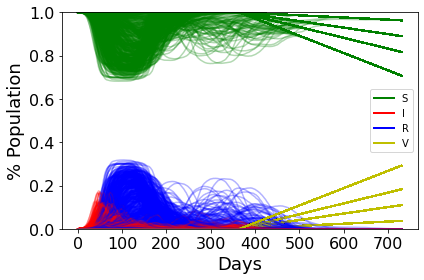

In [6]:
# Parameters to adjust (do all possible combinations of *0.7 and *1.3)
imlen = 90 # immunity length
adj = 1 # adjust the probability of infection
alph = 16.8 # damping factor; applied when logincrease = True

# Vary cut only if loginc is False
loginc = True
cut = 365 # cutoff; applied when logincrease = False

# Vaccination Parameters 
vacprop = 0.2 # proportion of vaccinated people (randomly selected)
vactime = 365 # time of vaccination (all vaccinated at once)
vacdays = 365 # days over which the vaccine is administered to the selected proportion of the population
hubs_first = True # if true vaccinate hubs first, otherwise random 

# Parameters of Interest
adjust_prob = adjust_prob*adj
prop_inf = [] # proportion of infected at the end 
max_infs = [] # maximum percentage of infecteds after vaccination starts 
no_peaks = [] # percentage of days that more than 1% of the pop'n is infected after vaccination starts 
max_reinf = [] # maximum number of reinfections that a node had after vaccination starts

# Get file names of the generated networks
pw = ['2.4', '2.6', '2.8', '3.0', '3.2'] # set of graphs with that power
tr = ['0.05', '0.1', '0.15', '0.2'] # set of graphs with that transitivity
vp = [0.05, 0.1, 0.2, 0.3]
output = pd.DataFrame(columns=['Nodes', 'Edges', 'Power', 'Transitivity', 'AdjPob', 'Vaccinated',
                               'max_infs', 'prop_inf', 'max_reinf', 'no_peaks'])
for vacprop in vp:
    print(vacprop)
    for _pw in pw:
        print(_pw)
        for _tr in tr:
            file_names = glob.glob('../Graphs/Graphs_{}_{}/*.pkl'.format(_pw, _tr))
            # Interate through the networks and run SIRS model
            for g_name in file_names:
                g = pickle.load(open(g_name,"rb"))
                if g.ecount() <= 2*(10**6):
                    pop = float(g.vcount()) # population size 
                    al = 0.3 # line transparancy
                    time = 730
                    power = power_law_fit(g.degree()).alpha
                    trans = g.transitivity_undirected()
                    # Run multiple simulation for each network
                    for i in range(10):
                        no_S,no_I,no_R,no_V,max_rI = run_SIRS_vaccine(g,days=time,
                                                                      infection_len=14,immunity_len=imlen,
                                                                      alpha=alph,cutoff=cut,
                                                                      logincrease=loginc, 
                                                                      vaccine_prop=vacprop, vaccine_time=vactime,
                                                                      vaccine_days=vacdays,
                                                                      vaccine_hubs=hubs_first)
                        # Save the parameters of interest
                        output = output.append({'Nodes':g.vcount(), 'Edges':g.ecount(), 
                                                'Power':power, 'Transitivity':trans, 
                                                'AdjPob': adj, 'Vaccinated': vacprop,
                                                'max_infs':max(no_I)*pop, 'prop_inf':no_I[-1]*pop, 
                                                'max_reinf':max_rI, 'no_peaks':np.sum([i>0.01 for i in no_I])}, ignore_index=True)

                        # Plot the trajectory of S,I,R,V
                        plt.plot(no_S, alpha = al, color = "g")
                        plt.plot(no_V, alpha = al, color = "y")
                        plt.plot(no_R, alpha = al, color = "b")
                        plt.plot(no_I, alpha = al, color = "r")
                        # Save the parameters of interst
                        max_reinf.append(max_rI)
                        prop_inf.append(no_I[-1]*pop)
                        max_infs.append(max(no_I)*pop)
                        no_peaks.append(np.sum([i>0.01 for i in no_I]))

# Add Legend
colors = ['g', 'r', 'b', 'y']
lines = [Line2D([0], [0], color=c, linewidth=2) for c in colors]
labels = ['S', 'I', 'R', 'V']
plt.legend(lines, labels)
plt.xlabel("Days",fontsize=18)
plt.ylabel("% Population",fontsize=18)
plt.ylim(0,1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("../Results/Vaccine/VaccinatedHub_Time{}_imlen{}.svg".format(vacdays,imlen))

#             # Save the figure 
#             if loginc:
#                 file = "power{}_tr{}_alpha{}_imlen{}_vaccine{}".format(_pw,_tr,alph,imlen, vacprop)
#                 file_name = file + ".png"
#             else:
#                 file = "power{}_tr{}_cutoff{}_imlen{}_vaccine{}".format(_pw,_tr,cut,imlen, vacprop)
#                 file_name = file + ".png"
#             current_file = "../Results/Vaccine/" + file_name
#             plt.savefig(current_file, bbox_inches='tight')

# Save Output to File 
if loginc:
    if hubs_first:
        output.to_csv("../Results/Vaccine/output_vaccine_loginc_alph{}_imlen{}_adj{}_vacdays{}_hubs.csv".format(alph,imlen,adj,vacdays))
    else: 
        output.to_csv("../Results/Vaccine/output_vaccine_loginc_alph{}_imlen{}_adj{}_vacdays{}.csv".format(alph,imlen,adj,vacdays))
else:
    if hubs_first:
        output.to_csv("../Results/Vaccine/output_vaccine_lininc_cut{}_imlen{}_adj{}_vacdays{}_hubs.csv".format(cut,imlen,adj,vacdays))
    else:
        output.to_csv("../Results/Vaccine/output_vaccine_lininc_cut{}_imlen{}_adj{}_vacdays{}.csv".format(cut,imlen,adj,vacdays))

In [7]:
test 

NameError: name 'test' is not defined

In [ ]:
colors